In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

Welcome to JupyROOT 6.12/06


/usr/local/lib/python2.7/dist-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.14.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
def bless_mcinfo(row):
    try:
        idx = tuple((row['run'],row['subrun'],row['event']))
        if MCInfo[idx]['nuPDG'] in [12,-12]:
            return 0
        else:
            return 1
    except:
        return 0
    
def bless_scedr(row):
    scedr = float(-1)
    dx = row['Xreco'] - row['parentSCEX']
    dy = row['Yreco'] - row['parentSCEY']
    dz = row['Zreco'] - row['parentSCEZ']
    dr2 = dx*dx+dy*dy+dz*dz
    dr = np.sqrt(dr2)
    
    scedr = dr
    return scedr

In [3]:
def distplot(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax.set_title('MCC9 Data/MC',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels)
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    print 'Events:',vals_data.sum()

In [4]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax,writepval=False):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)
    
    a_labels_evts = []
    
    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())
    
    yerr_mc = np.sqrt(yerr_mc)
        
    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())
    
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc),2) + np.power(np.divide(np.sqrt(vals_data),vals_data),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, len(er_rat)) 
    
    
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
    
    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

    
    plt.tight_layout()
    print 'Events:',vals_data.sum()
    print 'MC: ',vals_mc.sum()
    return ax0

## Load  Things Up

In [5]:
NUMU_POT = 1.182344587853327e+21
NUMU_POT_BNB5E19RANGE = 5.534263853054876e+19

NUE_POT = 1.0830766933130594e+23
NUE_POT_BNB5E19RANGE = 2.110675254122294e+21

DATA_POT_UNCORRECTED = 3.541e+19
DATA_POT_CORRECTED = 4.365e+19
DATA_POT_EMPTY = 9.283e+15
DATA_POT = DATA_POT_CORRECTED + DATA_POT_EMPTY

EXT_POT_UNCORRECTED = 6361606.0 / 8862735.0 * 3.985e+19
#EXT_POT_CORRECTED = 12163846.0 / 19342610.0 * 8.119e+19
#EXT_POT_EMPTY = 6.988485e16
#EXT_POT =EXT_POT_CORRECTED + EXT_POT_EMPTY
EXT_POT = (12163846.0 + 15585) / float (10149967+2220) * DATA_POT
EXT_POT_BNB5E19RANGE  = (5124649 + 9298) / float (10149967+2220) * DATA_POT


POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)

DATA_SCALE_UNCORRECTED = 1.0
EXT_SCALE_UNCORRECTED = DATA_POT_UNCORRECTED / EXT_POT_UNCORRECTED

print EXT_POT_UNCORRECTED
print EXT_POT_BNB5E19RANGE
print EXT_SCALE
print DATA_SCALE
print DATA_POT_CORRECTED

2.86040369141e+19
2.2078439353e+19
0.833551830131
1.0
4.365e+19


In [6]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Oct31_fullrange'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_pmtprecut_%s.pkl'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_pmtprecut_%s.pkl'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_pmtprecut_%s.pkl'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_pmtprecut_%s.pkl'%tag)

In [7]:
s_presel = 'PassCuts == 1 and N5cmTracks == 2'

s_loosecuts = 'Lepton_EdgeDist > 2 and Proton_EdgeDist > 2 and InFiducial == 1 and N5cmTracks == 2 and NTracks == 2'

s_isolatebump = s_presel + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
s_presel_conservative = s_presel + ' and BDTprob != -1'

s_presel_naughtybits = s_presel + ' and BDTprob == -1'

s_cuts = s_presel

df_numu_presel = df_numu_goodruns_pmtprecut.query(s_cuts)
df_nue_presel = df_nue_goodruns_pmtprecut.query(s_cuts)
df_ext_presel = df_ext_goodruns_pmtprecut.query(s_cuts)
df_data_presel = df_data_goodruns_pmtprecut.query(s_cuts)

weights_numu_presel = df_numu_presel['geniereweight']*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE

In [8]:
a_weights = [weights_numu_presel,weights_nue_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','EXTBNB (5e19 Range)']
a_colors = ['mediumspringgreen','c','mediumorchid']

Events: 7131.0
MC:  6099.302781898795


Text(0.7,0.7,'Fiducial, Two-Track,and \\nContainment Cuts Applied')

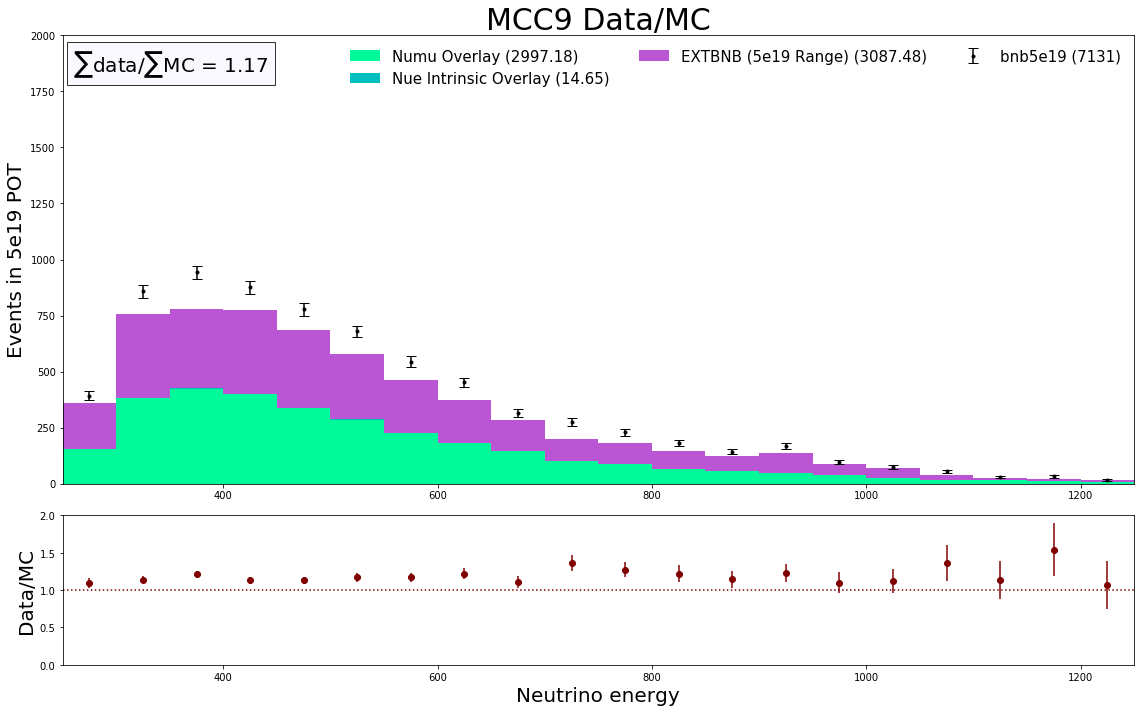

In [9]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values

fig,ax = plt.subplots(figsize=(16,10))
distplot_wratio(20,(250,1250),[var_numu,var_nue,var_ext],var_data,weights_data_presel,'Neutrino energy',2e3)
ax.annotate(r'Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)


## This is where the magic happens

In [10]:
df_offvtx_numu_presel = df_numu_presel.query('scedir_corrected > 5')

df_CCQE_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1000')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1080 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplusminus= '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+pizero)
df_piplusminus_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+piplusminus)
df_other_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType!=1001 and interactionType!=1000 and not '+pizero+' and not '+piplusminus)

weights_offvtxnumu_presel = df_offvtx_numu_presel['geniereweight']*NUMU_SCALE
weights_CCQEnumu_presel = df_CCQE_numu_presel['geniereweight']*NUMU_SCALE
weights_MECnumu_presel = np.ones(len(df_MEC_numu_presel))*NUMU_SCALE
weights_PIZEROnumu_presel = np.ones(len(df_pizero_numu_presel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_presel = np.ones(len(df_piplusminus_numu_presel))*NUMU_SCALE
weights_OTHERnumu_presel = np.ones(len(df_other_numu_presel))*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE


a_weights = [weights_CCQEnumu_presel,weights_MECnumu_presel,weights_PIZEROnumu_presel,weights_PIPLUSMINUSnumu_presel,weights_OTHERnumu_presel,weights_offvtxnumu_presel,weights_nue_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]

a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']

Events: 7131.0
MC:  6099.302781898879


Text(0.75,0.6,'Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1')

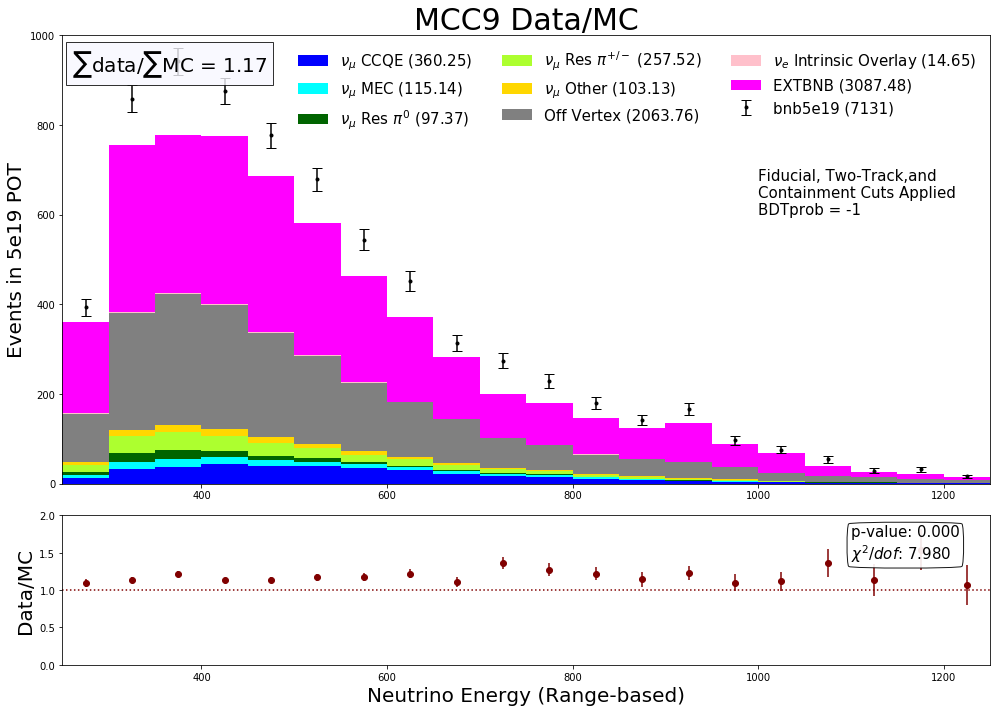

In [11]:
vartest = 'Enu_1m1p'
nbins = 20
myrange = (250,1250)

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,'Neutrino Energy (Range-based)',1e3,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)


/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Events: 6306.0
MC:  5426.876480035917


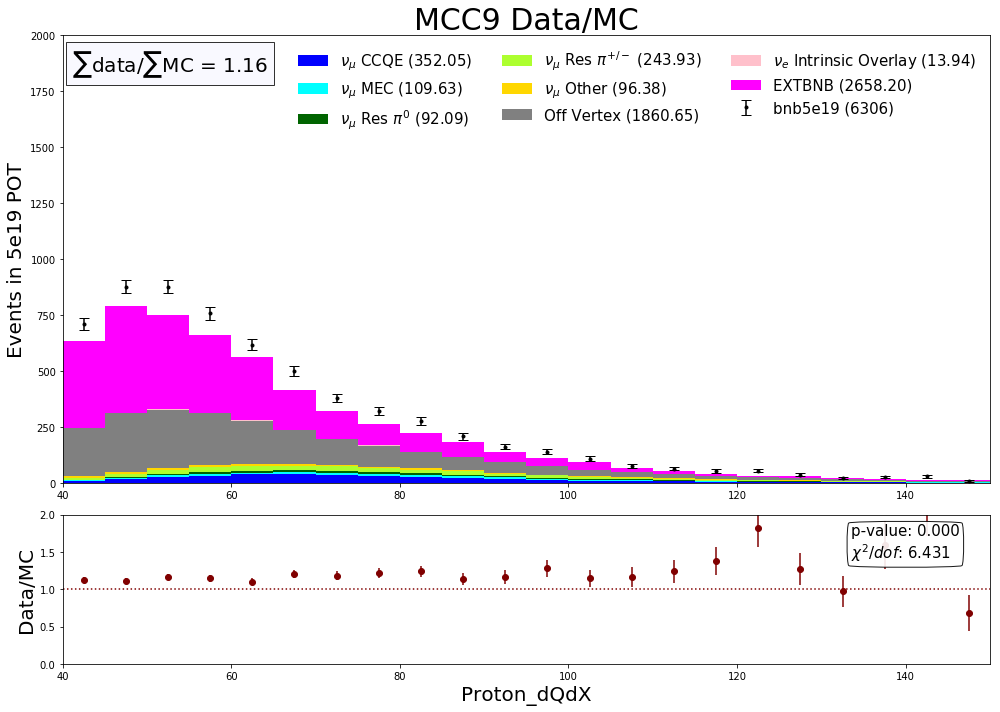

In [13]:
vartest = 'Proton_dQdx'
nbins = 22
myrange = (40,150)

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,'Proton_dQdX',2e3,True)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 7173.0
MC:  6122.342171653822


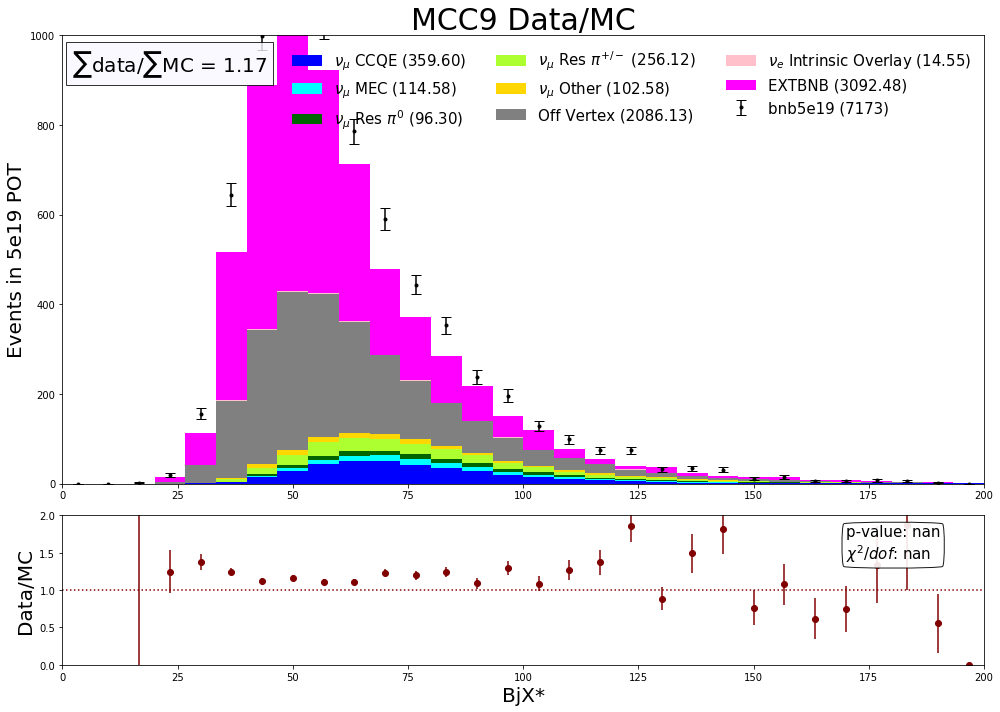

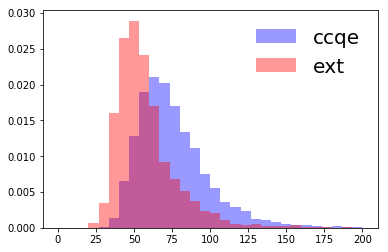

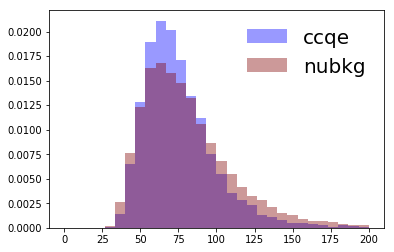

In [15]:
testvar = 'BjXB_1m1p'
myrange = (0,200)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,'BjX*',1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 7200.0
MC:  6152.487701605207


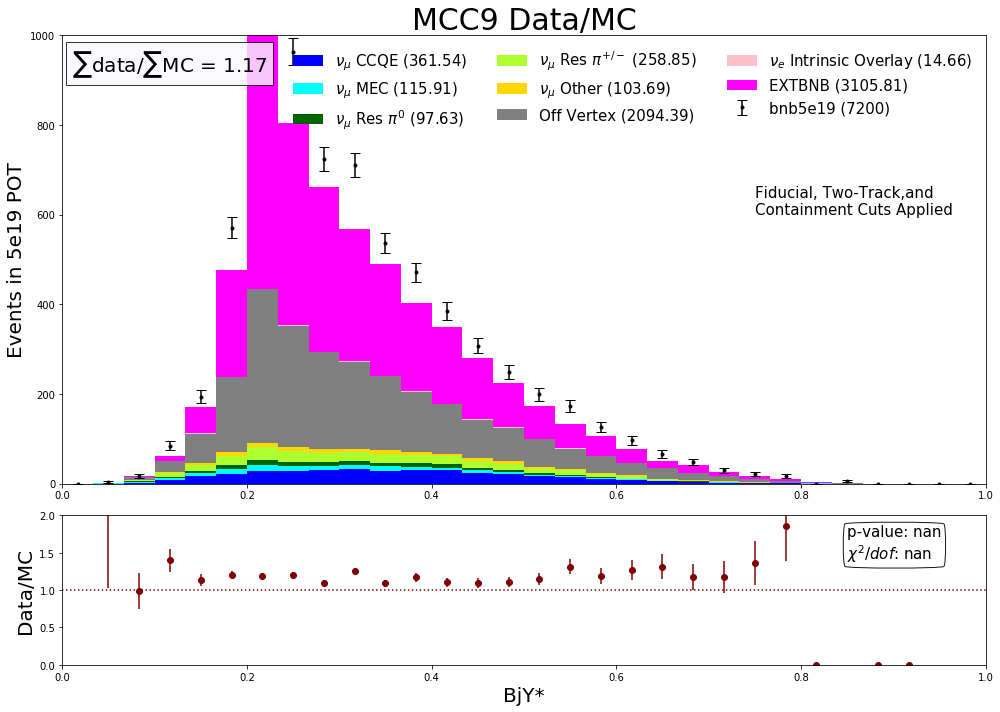

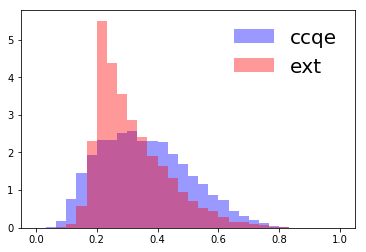

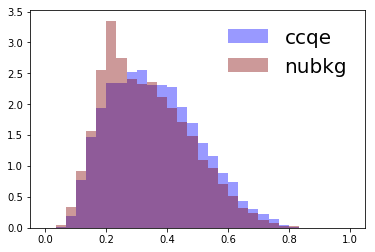

In [16]:
vartest = 'BjYB_1m1p'
myrange = (0,1)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,'BjY*',1e3,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7200.0
MC:  6152.487701605225


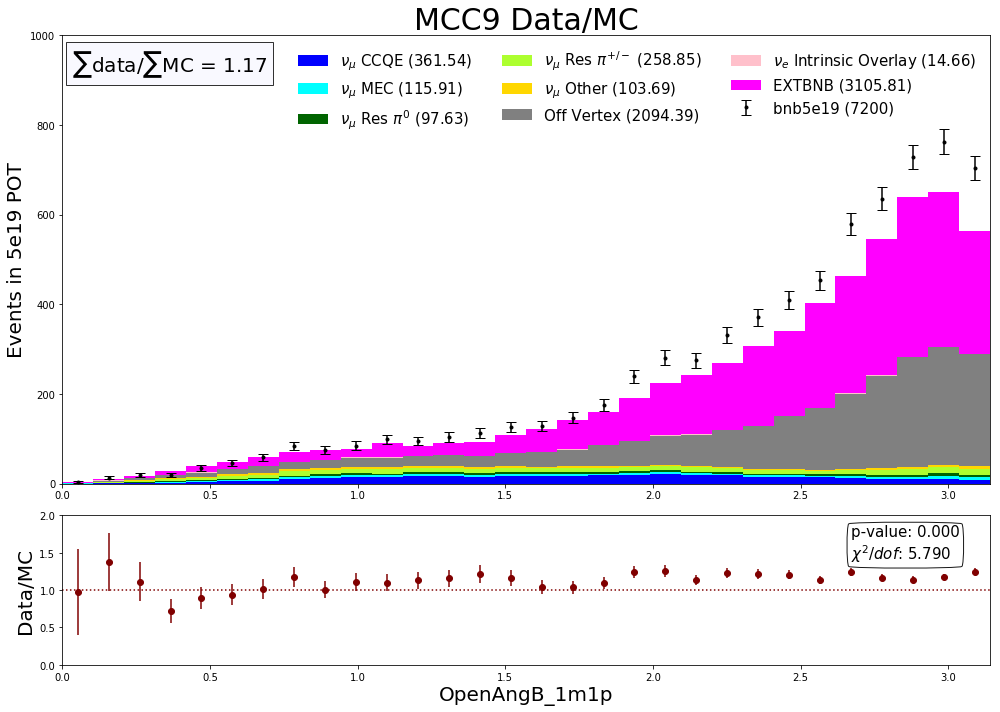

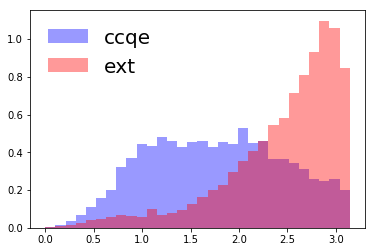

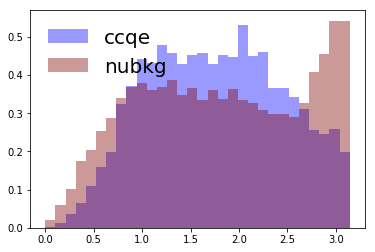

In [17]:
vartest = 'OpenAngB_1m1p'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7178.0
MC:  6132.2565032596785


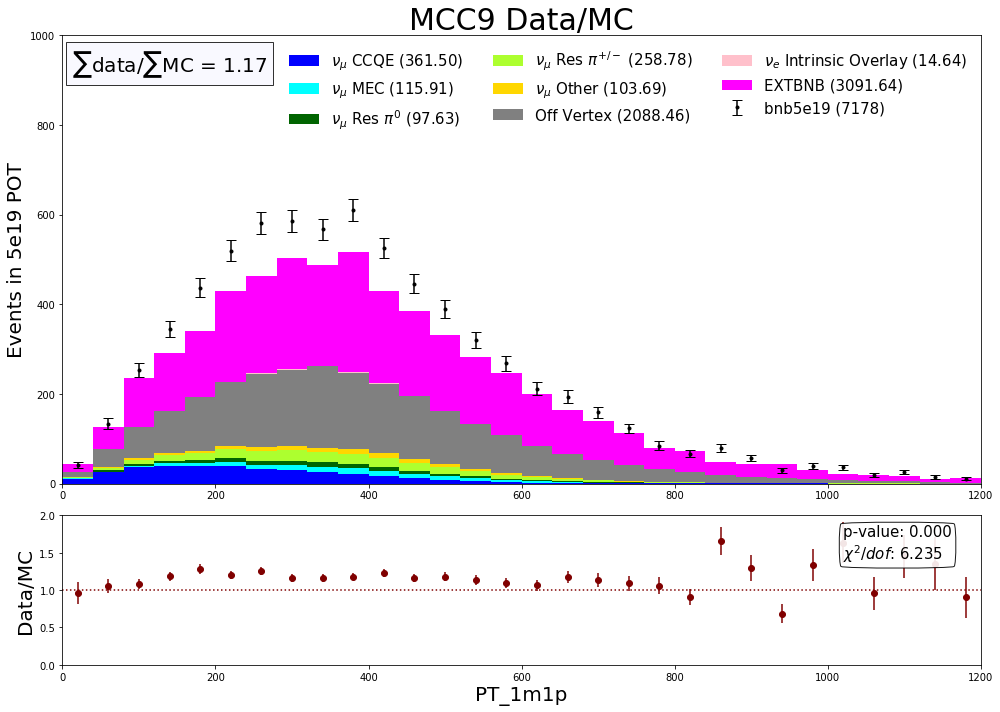

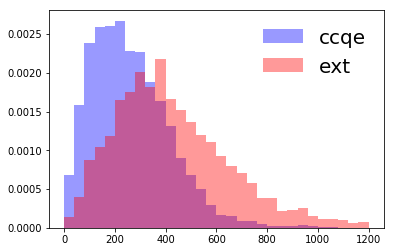

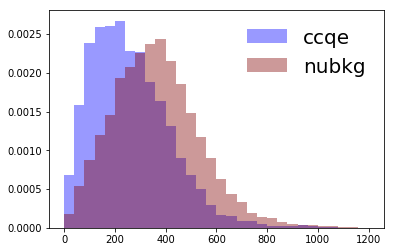

In [18]:
vartest = 'PT_1m1p'
myrange = (0,1200)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

In [17]:
list(df_CCQE_numu_presel)

['geniereweight',
 'scedir_corrected',
 'run',
 'subrun',
 'event',
 'vtxid',
 'Xreco',
 'Yreco',
 'Zreco',
 'VtxAlgo',
 'InFiducial',
 'AnyReco',
 'NTracks',
 'N5cmTracks',
 'PassCuts',
 'PassShowerReco',
 'PassSecShr',
 'Good3DReco',
 'Eta',
 'OpenAng',
 'Thetas',
 'Phis',
 'ChargeNearTrunk',
 'LongTrackLen',
 'ShortTrackLen',
 'PIDmu',
 'PIDsh',
 'PIDp',
 'PIDg',
 'PIDe',
 'MaxShrFrac',
 'MinShrFrac',
 'BDTprob',
 'CCQEEnergyShift_1m1p',
 'Enu_1m1p',
 'PhiT_1m1p',
 'AlphaT_1m1p',
 'PT_1m1p',
 'PTRat_1m1p',
 'BjX_1m1p',
 'BjY_1m1p',
 'Q2_1m1p',
 'Sph_1m1p',
 'PzEnu_1m1p',
 'OpenAngB_1m1p',
 'ThetasB_1m1p',
 'PhisB_1m1p',
 'PhiTB_1m1p',
 'AlphaTB_1m1p',
 'PTB_1m1p',
 'BjXB_1m1p',
 'BjYB_1m1p',
 'Q2B_1m1p',
 'SphB_1m1p',
 'CCQEEnergyShift_1e1p',
 'Enu_1e1p',
 'PhiT_1e1p',
 'AlphaT_1e1p',
 'PT_1e1p',
 'PTRat_1e1p',
 'BjX_1e1p',
 'BjY_1e1p',
 'Q2_1e1p',
 'Sph_1e1p',
 'PzEnu_1e1p',
 'OpenAngB_1e1p',
 'ThetasB_1e1p',
 'PhisB_1e1p',
 'PhiTB_1e1p',
 'AlphaTB_1e1p',
 'PTB_1e1p',
 'BjXB_1e1p',

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 7170.0
MC:  6131.8859199628205


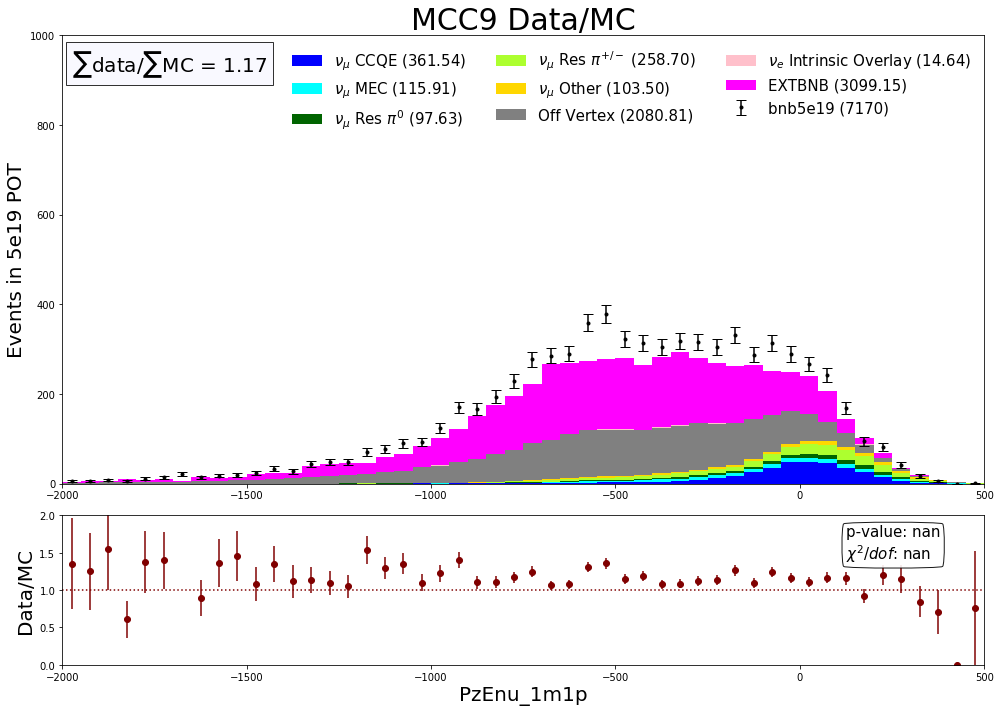

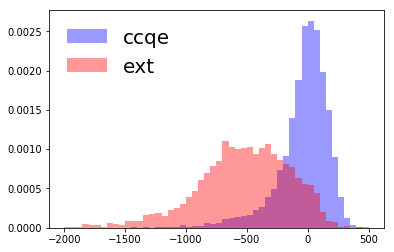

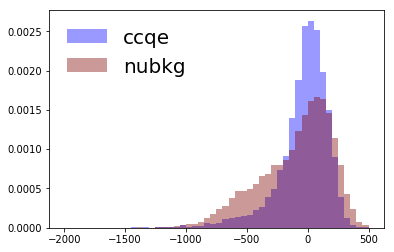

In [37]:
vartest = 'PzEnu_1m1p'
myrange = (-2000,500)
nbins = 50

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 6836.0
MC:  5876.42617651007


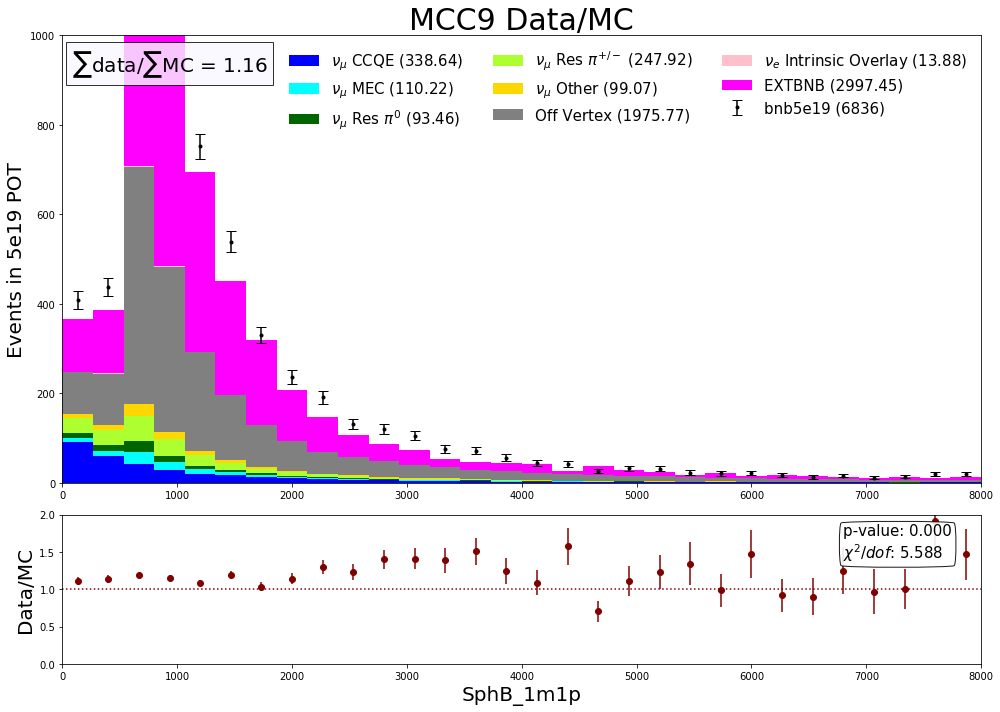

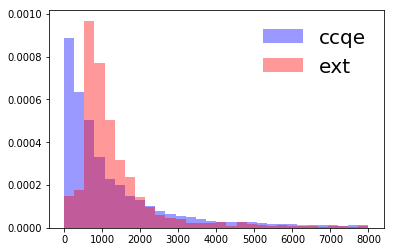

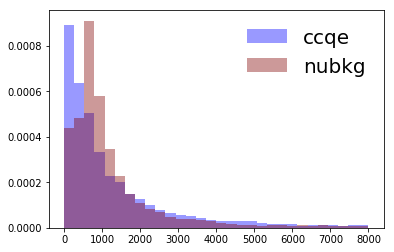

In [21]:
vartest = 'SphB_1m1p'
myrange = (0,8000)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7200.0
MC:  6152.487701605349


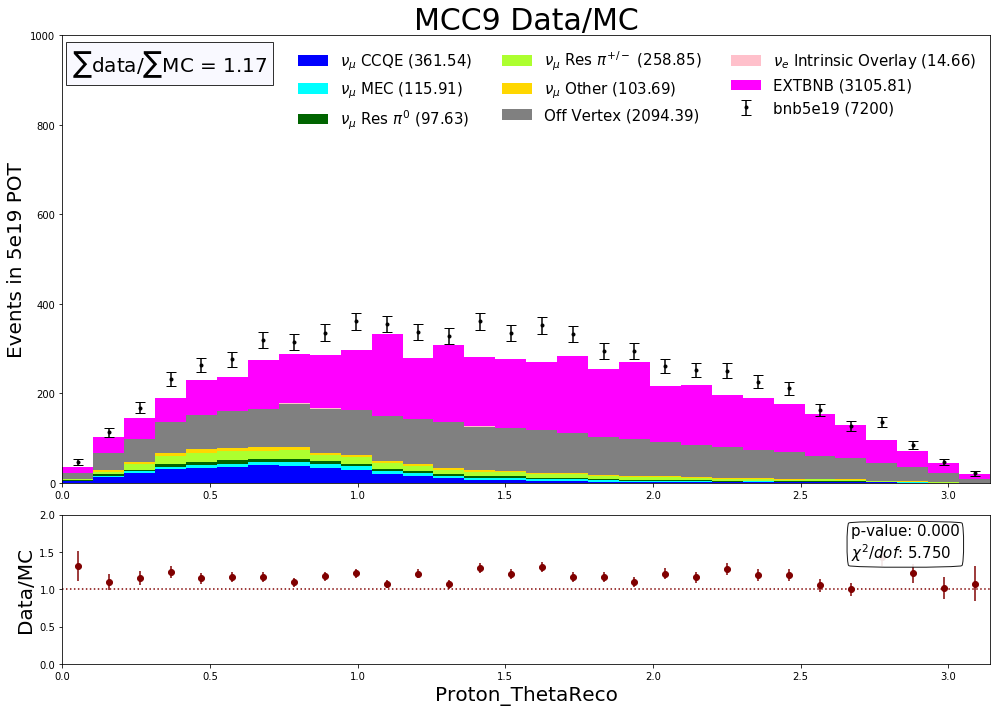

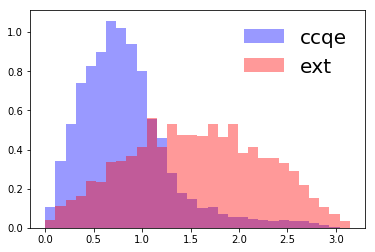

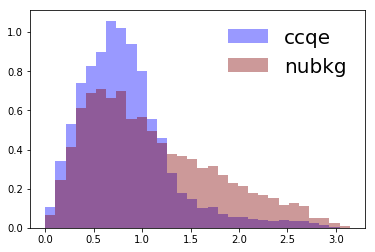

In [22]:
vartest = 'Proton_ThetaReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7200.0
MC:  6152.487701605349


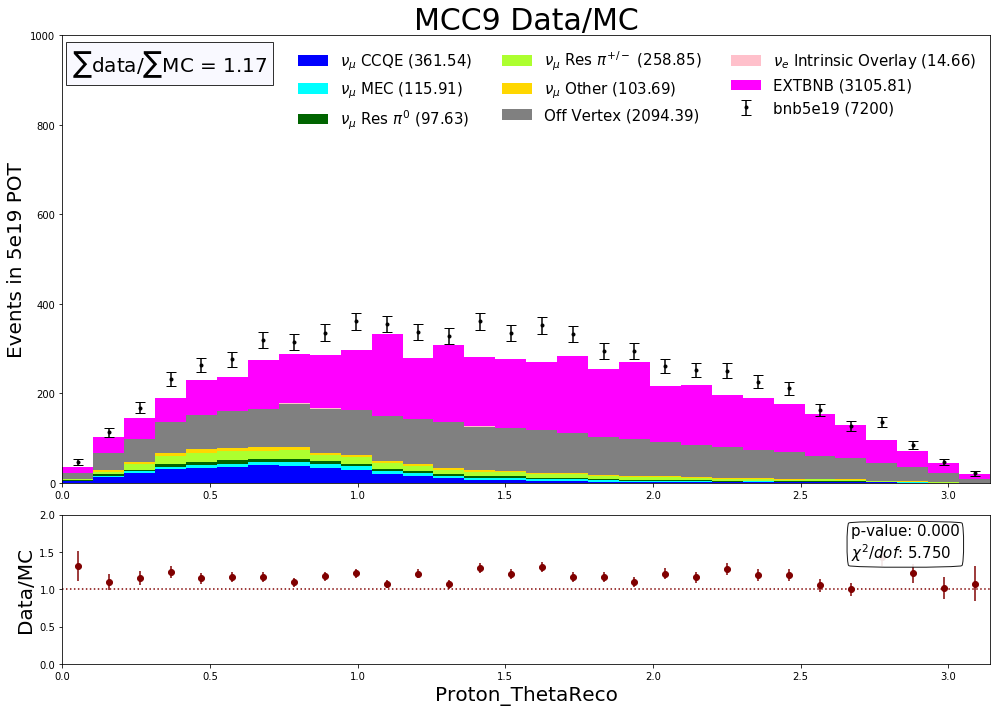

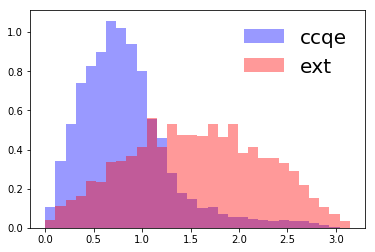

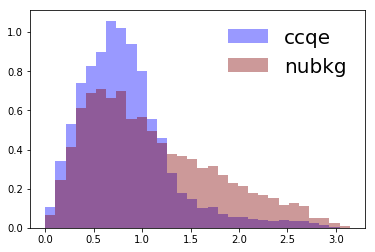

In [23]:
testvar = 'Proton_ThetaRecoB'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7200.0
MC:  6152.487701605348


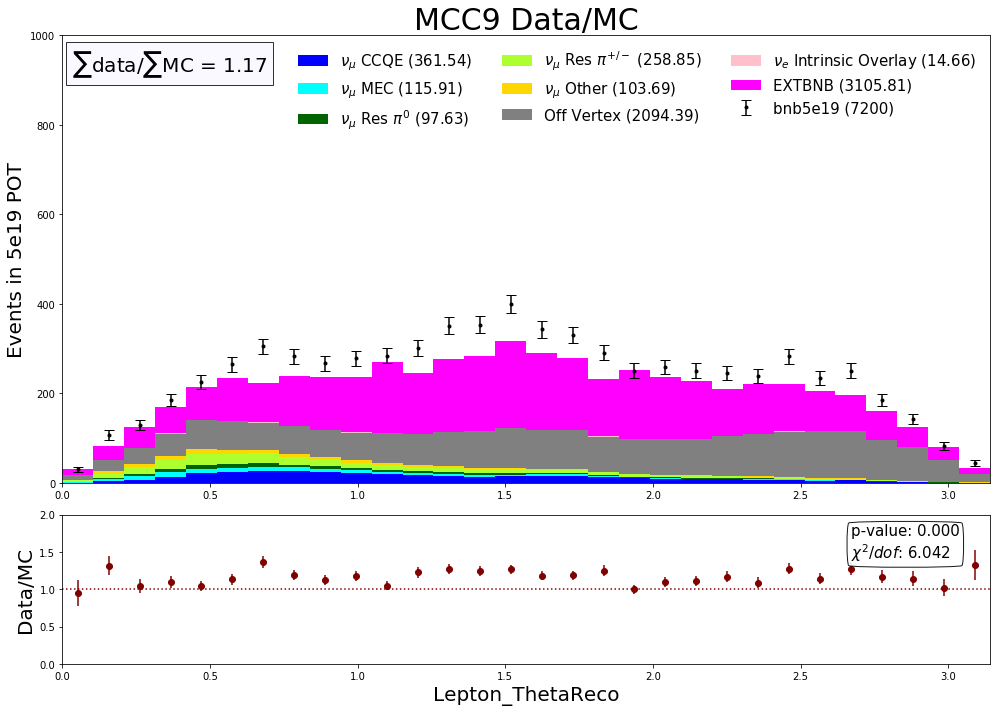

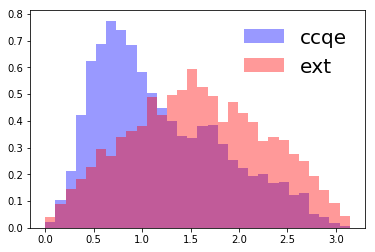

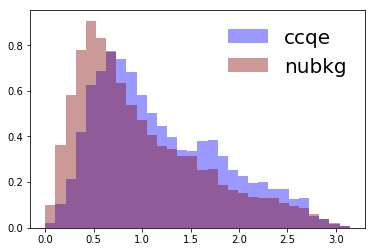

In [29]:
vartest = 'Lepton_ThetaReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 4520.0
MC:  3866.760954950984


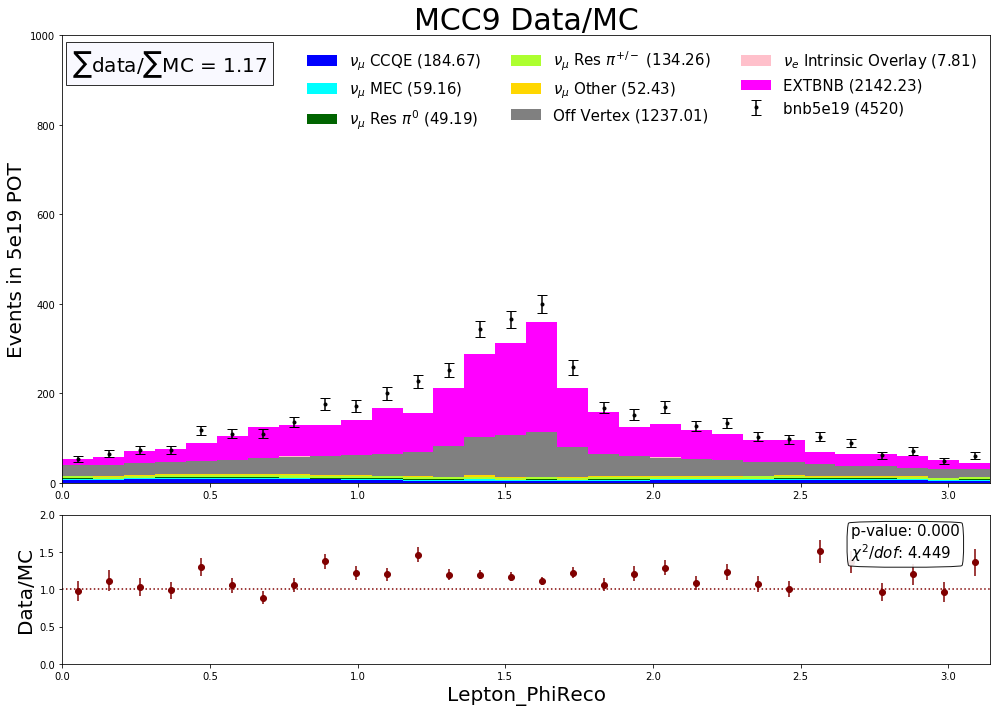

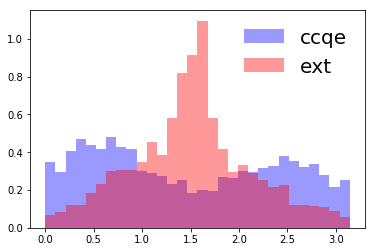

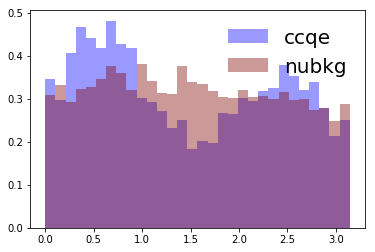

In [30]:
vartest = 'Lepton_PhiReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 3433.0
MC:  2935.8585354149554


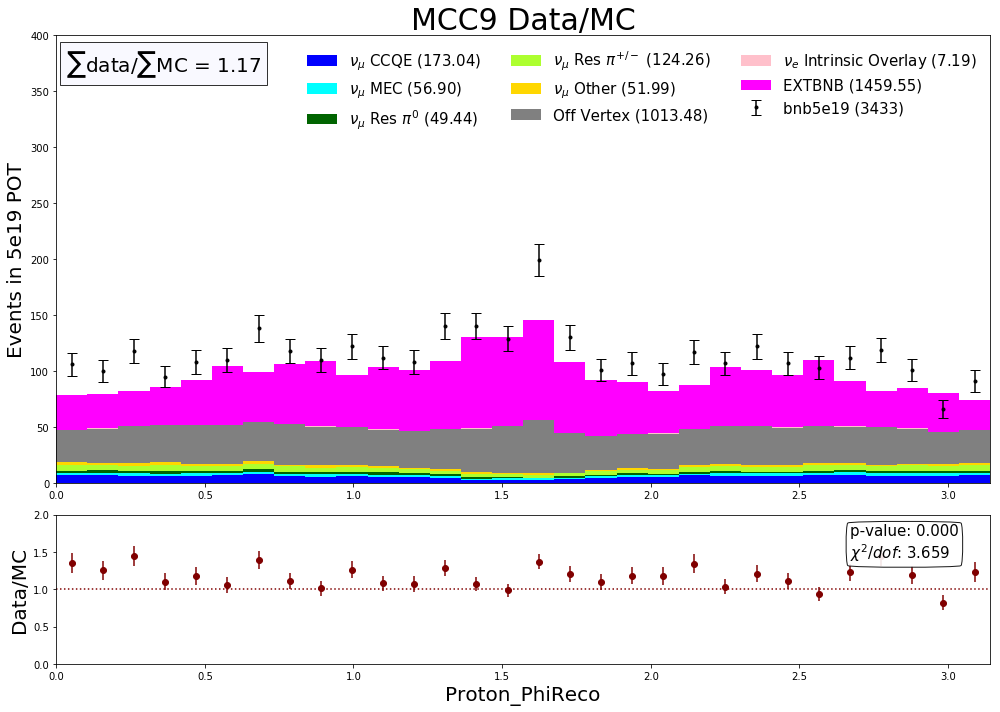

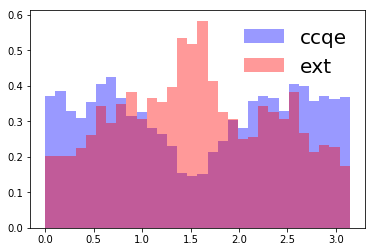

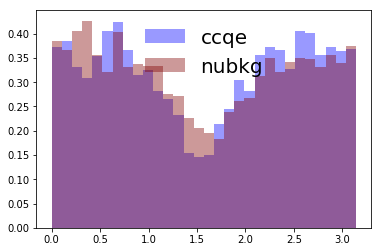

In [35]:
vartest = 'Proton_PhiReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,.4e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

Events: 7200.0
MC:  6152.487701605348


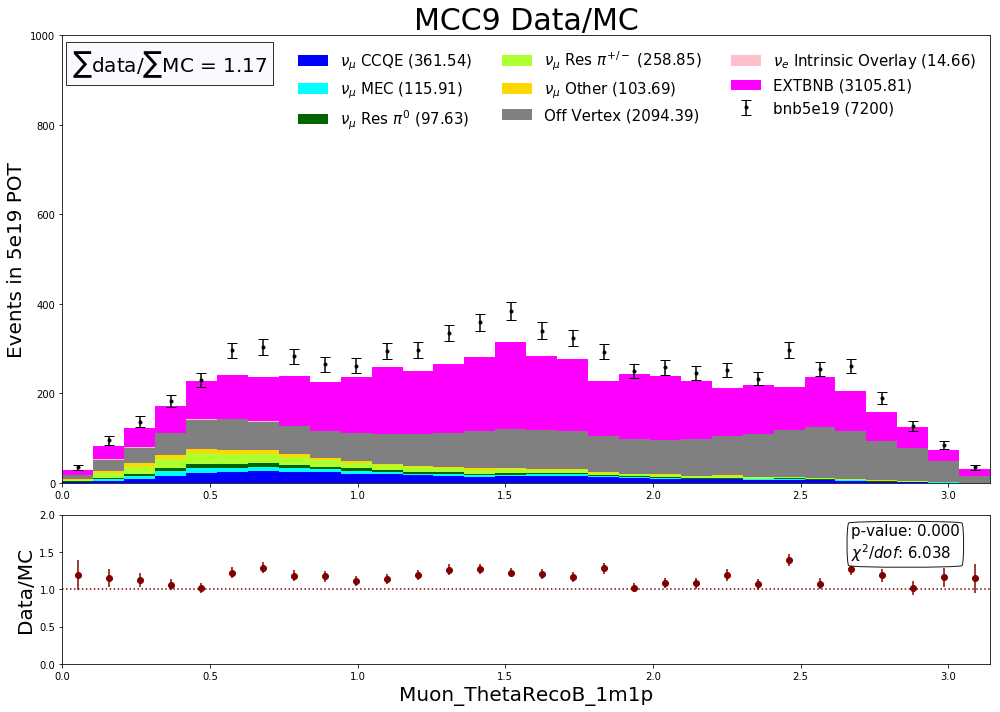

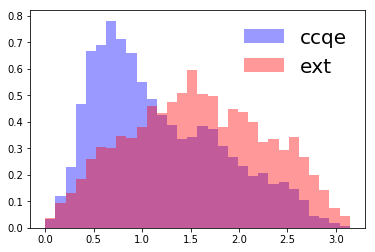

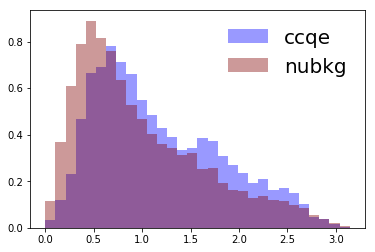

In [33]:
vartest = 'Muon_ThetaRecoB_1m1p'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,1e3,True)
#ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied\nBDTprob = -1',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax.hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
_=plt.legend(frameon=False,fontsize=20)

In [28]:
df_signal = df_CCQE_numu_presel
df_extbkg = pd.concat([df_ext_presel,df_offvtx_numu_presel.query('run>=5119 and run<=5955')])
df_nubkg = pd.concat([df_piplusminus_numu_presel,df_pizero_numu_presel,df_other_numu_presel,df_MEC_numu_presel])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


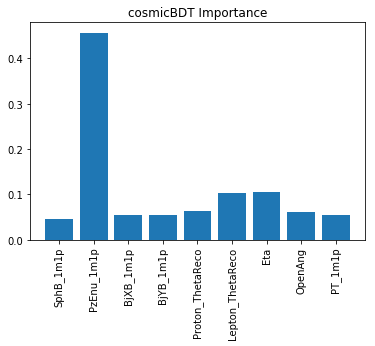

In [37]:
# Cosmic vs numu
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaReco','Lepton_ThetaReco','Eta','OpenAng','PT_1m1p']

vars_v1 = ['eta','openAng','pT','pzEnu','sph','Proton_ThetaReco']

myvars = jarretvars

X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(max_depth=10,n_estimators=500)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

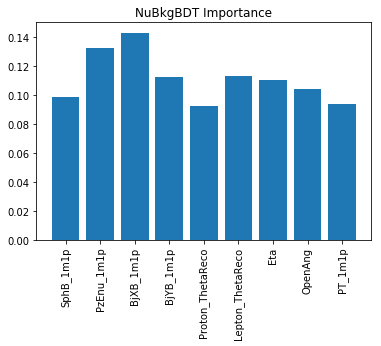

In [38]:
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaReco','Lepton_ThetaReco','Eta','OpenAng','PT_1m1p']

vars_v1 = ['eta','bjYB','openAngB','pT','pzEnu','sphB','Proton_ThetaRecoB']

myvars = jarretvars

X = df_nue_presel[myvars].values.tolist()
Y_nubkg = df_nubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_nubkg))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_nubkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier(max_depth=10,n_estimators=500)
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

In [39]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweights_1mu1p_vNov1.pickle", "wb" ))

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = cosmicBDT.predict(X ,output_margin=True)
bdt_score_ext = cosmicBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-10,10),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = cosmicBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-10,10),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Cosmic Background Score')

plt.legend()

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict(X ,output_margin=True)
bdt_score_ext = nubkgBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-7.5,5),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-7.5,5),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()